In [1]:
%matplotlib inline

import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium

on charge les contours géométriques qu'on utilisera :

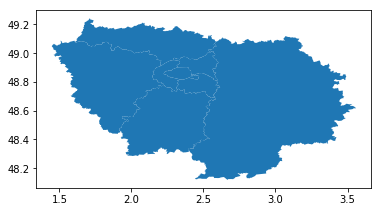

In [2]:
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones.head()
zones.plot()

On charge les données OSM et GTFS de routepoints :

In [3]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
#gtfs_routepoints.head()

On ajoute la dimension géographique aux données officielles :

In [4]:
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_routepoints.drop('gtfs_stop_lon', axis=1, inplace=True)
gtfs_routepoints.drop('gtfs_stop_lat', axis=1, inplace=True)

crs = {'init': 'epsg:4326'}
gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)


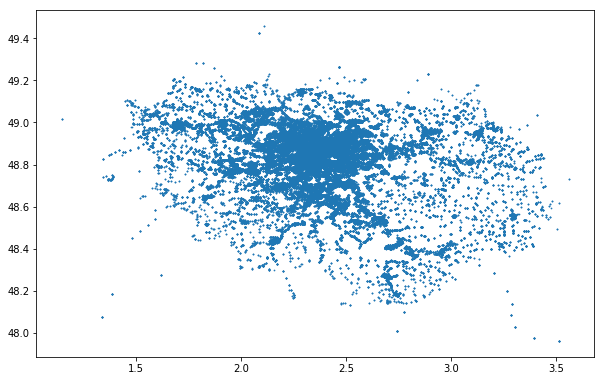

In [5]:
gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

On calcule le nombre de routepoints par départements dans le jeu de données officiel :

In [6]:
gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones[['name', 'geometry']].copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

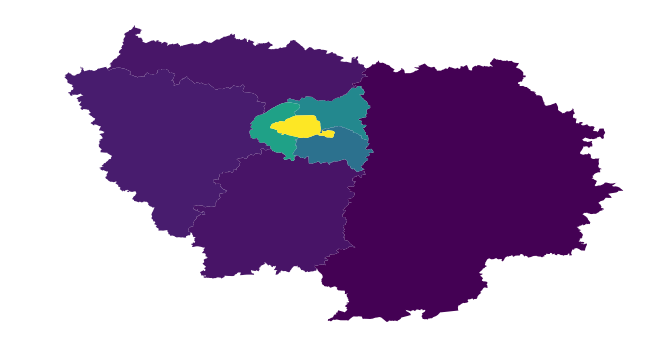

In [7]:
zones_with_gtfs_count['densite'] = zones_with_gtfs_count['nb_stops_officiel'] / zones_with_gtfs_count.geometry.area
#l'aire calculée est ... étrange ...

ax = zones_with_gtfs_count.plot(column='densite', figsize=(15, 6))
ax.set_axis_off()

#WTF : on comprend rien à rien à cette échelle de couleurs u_u

In [8]:
zones_with_gtfs_count

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stops_officiel,densite
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26004,35962.450641
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8939,307469.791796
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14701,66361.563898
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10638,68970.185639
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7965,370143.551495
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22397,79289.241419
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7599,253606.487256
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",7992,618903.204016


On ajoute la dimension géographique aux données OSM :

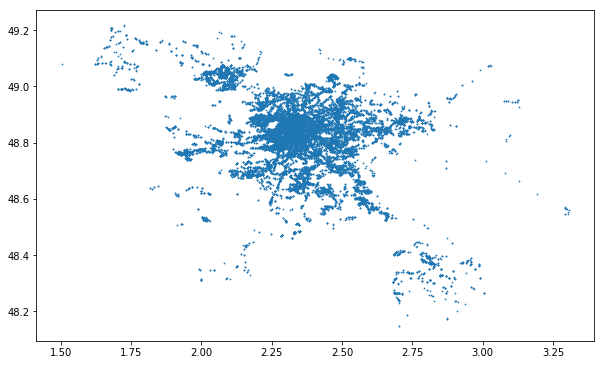

In [9]:
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

crs = {'init': 'epsg:4326'}
osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
osm_geo.plot(markersize=0.5, figsize=(10, 10))
#TODO : il y a des clusters amusants, regarder plus en détail où ils sont

On calcule le nombre de routepoints par départements dans les données OSM :

In [10]:
osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones[['name', 'geometry']].copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_osm_count = zones.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_osm_count

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stops_osm
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",2800
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",2181
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",3495
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",2948
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3420
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",1687
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3378
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",4431


On fusionne les deux et on normalise pour avoir le pourcentage de couverture d'OSM par rapport à l'officiel :

In [11]:
zones_with_counts = zones_with_gtfs_count.merge(zones_with_osm_count[['nb_stops_osm', 'name']].copy(),on='name')
zones_with_counts["couverture_osm"] = zones_with_counts["nb_stops_osm"] * 100.0 / zones_with_counts["nb_stops_officiel"]
zones_with_counts
#TODO : à comparer avec les chiffres bruts du nombre d'arrêts pour vérifier si c'est cohérent

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stops_officiel,densite,nb_stops_osm,couverture_osm
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26004,35962.450641,2800,10.767574
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8939,307469.791796,2181,24.398702
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14701,66361.563898,3495,23.773893
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10638,68970.185639,2948,27.711976
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7965,370143.551495,3420,42.937853
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22397,79289.241419,1687,7.532259
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7599,253606.487256,3378,44.453218
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",7992,618903.204016,4431,55.442943


In [12]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_counts, data=zones_with_counts, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

?? tenter un groupby par agency et un merge pour avoir des stats par réseau ? ça risque de pas matcher souvent ...

In [13]:
len(list(set(osm_routepoints['osm_network'])))
len(list(set(gtfs_routepoints['gtfs_agency_name'])))

119

In [14]:
osm_networks = pd.DataFrame(osm_routepoints.groupby('osm_network').size()).reset_index()
gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
networks = gtfs_networks.merge(osm_networks, how='outer', right_on=['osm_network'], left_on=['gtfs_agency_name'])
networks.rename(columns={'0_x': 'gtfs_count', '0_y': 'osm_count'}, inplace=True)
networks


,gtfs_agency_name,gtfs_count,osm_network,osm_count
0,ADP,15.0,NaN,NaN
1,AUTOCARS DOMINIQUE,32.0,NaN,NaN
2,Actipôles,306.0,NaN,NaN
3,Albatrans,437.0,NaN,NaN
4,Apolo 7,909.0,Apolo 7,164.0
5,Arlequin,487.0,Arlequin,50.0
6,Aubergenville,57.0,NaN,NaN
7,Autobus du Fort,44.0,Autobus du Fort,11.0
8,Autocars Tourneux,1126.0,NaN,NaN
9,Aérial,638.0,Aérial,40.0
